# PROBLEM DEFINITION
The production system consists of six machines, each considered unbreakable (no maintenance required).

This production system is responsible for producing three different families of products, each family needs a different floor routing and different processing tims for each machine

## DATA
- **6 machines**
- **3 product families**
- **Job arrival rate (exponential)** lambda 0.65
- **Families’ weights**
    - F1: 10%
    - F2: 52%
    - F3: 38%
- **Families' floor routings**

    ![Testo alternativo](floor_routing.png)
- **Families processing times**
    - F1: gamma distribution, alpha=2, beta=2
    - F2: gamma distribution, alpha=4, beta=0.5
    - F2: gamma distribution, alpha=6, beta=1/6
- **Due dates**
Uniform: U(30, 50)


## GOAL 1

Students must implement a simulation of the environment managed using the “PUSH” policy: whenever a new customer order is received, it is immediately released into the shop ﬂoor.

The PUSH policy serves as the benchmark for comparison with the RL-based solution.

# GOAL 1, throughput

All the imports are grouped here

In [70]:
import simpy
from typing import Dict, Tuple, List

import time
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math

In [2]:
class Family:
    def __init__(self, name, floor_routing, processing_time, arrival_rate):
        self.name : str = name
        self.floor_routing : Dict[str, int] = floor_routing
        self.processing_time: Tuple[int, int] = processing_time
        self.arrival_rate : int = arrival_rate
    
    def machine_processing_time(self, job_rng):
        return job_rng.gammavariate(alpha = self.processing_time[0], beta = self.processing_time[1])
    
    def __str__(self):
        return self.name
    
FAMILIES = {"F1" : Family("F1", {"WC1": 1, "WC2": 1, "WC3": 0, "WC4": 1, "WC5":1, "WC6": 1}, (2, 2), 10),
            "F2" : Family("F2", {"WC1": 0.8, "WC2": 0.8, "WC3": 1, "WC4": 0.8, "WC5":0.8, "WC6": 0.75}, (4, 0.5), 52),
            "F3" : Family("F3", {"WC1": 0, "WC2": 0, "WC3": 1, "WC4": 0, "WC5":0, "WC6": 0.75}, (6, 1/6), 38)
            }  

In [3]:
from IPython.display import Markdown, display

FAMILIES_OUTPUT_COLORS = {
    "F1": "red",
    "F2": "orange",
    "F3": "green"
}
def color_print(family_name, text):
    color = FAMILIES_OUTPUT_COLORS[family_name]
    display(Markdown(f"<span style='color:{color}; font-weight:bold'>{text}</span>"))

In [4]:
class Job:
    def __init__(self, env, family, id, this_job_rng):
        self.env = env
        self.family = family
        self.this_job_rng = this_job_rng
        self.id = id
        
    def process(self, shopfloor):
        for machine_name, machine_probability in self.family.floor_routing.items():
            if self.this_job_rng.random() < machine_probability:
                with shopfloor.machines[machine_name].request() as request:
                    #start waiting to be processed
                    yield request
                    #end of waiting
                    yield self.env.timeout(self.family.machine_processing_time(self.this_job_rng))
            else:
                self.this_job_rng.random()
                #to consume random numbers in same order
        
        shopfloor.statistics.raw_statistics["time_finished_task"].append(self.env.now)
        #color_print(self.family.name,f"Order just delivered! id:{self.id}")

Generate task of random family

In [5]:
def sample_family(family_rng) -> Family:
    family_names = list(FAMILIES.keys())
    family_probability = list(FAMILIES[name].arrival_rate for name in family_names)
    
    sampled_family = family_rng.choices(family_names, weights=family_probability, k = 1)[0]
    return Family(sampled_family, FAMILIES[sampled_family].floor_routing, FAMILIES[sampled_family].processing_time, FAMILIES[sampled_family].arrival_rate )

Shape each machine as a simpy.Resource with capacity 1.
Not one simpy.Resource with capacity = 6 because the machines differ one from another.

In [6]:
class Machine(simpy.Resource):
    def __init__(self, type_name : str, env: simpy.Environment, capacity: int = 1) -> None:
        super().__init__(env, capacity)
        self.env = env
        self.type_name = type_name

Shape each job, making it flow in machines according to its family

Shape shop floor:
* generates jobs
* decide when to push jobs in the sho floor (with PUSH) policy
* measure statistics

In [7]:
class Statistics:
    def __init__(self):
        self.raw_statistics={"time_finished_task": []}
        self.replication_statistics={"throughput": []}

In [20]:
class ShopFloor:
    def __init__(self, env: simpy.Environment, job_rng, family_rng):
        self.env = env
        self.job_rng = job_rng
        self.family_rng = family_rng
        
        self.orders = []
        self.job_id = 1
        self.statistics = Statistics()

        self.machines = {
            "WC1": Machine("WC1", env),
            "WC2": Machine("WC2", env),
            "WC3": Machine("WC3", env),
            "WC4": Machine("WC4", env),
            "WC5": Machine("WC5", env),
            "WC6": Machine("WC6", env)         
        }
    
    def job_generator(self):
        while True:
            yield self.env.timeout(self.job_rng.expovariate(lambd= 0.65))
            
            this_job_rng_seed = self.job_rng.randint(0, 10_000_000)
            this_job_rng = random.Random(this_job_rng_seed)
            
            new_job = Job(self.env, sample_family(self.family_rng), self.job_id, this_job_rng)
            self.job_id += 1
            self.orders.append(new_job)
            
            #color_print(new_job.family.name, f'New order! It is {new_job.family} id:{new_job.id}')

    def evaluate_metrics(self):
        while True:
            yield self.env.timeout(60)
            
            # every 60 minutes' throughput for Welch evaluation
            n_tasks = len(self.statistics.raw_statistics["time_finished_task"])
            n_minutes = self.env.now
            new_throughput = n_tasks / (n_minutes / 60)
            self.statistics.replication_statistics["throughput"].append(new_throughput)
              
    def run(self):
        while True:
            if self.orders:
                job = self.orders.pop(0)
                self.env.process(job.process(self))
            yield self.env.timeout(1/60)  #to be able to simulate, go on every second

Specify:
* simulation length (in minutes)
* random generator seeds (both for job_seed and family_seed) 

In [21]:
def run_system(job_seed, family_seed, simulation_length: int):
    env = simpy.Environment()
    
    job_rng = random.Random(job_seed)
    family_rng = random.Random(family_seed)
    
    shopfloor = ShopFloor(env = env, job_rng= job_rng, family_rng = family_rng)
    env.process(shopfloor.job_generator())
    env.process(shopfloor.evaluate_metrics())
    env.process(shopfloor.run())
    env.run(until = simulation_length)
    
    return shopfloor.statistics

Run 10 different replications of the same simulation (same parameters, different seeds for random numbers)

In [60]:
replications_statistics = {"throughput": []}
for seed in range(1,11):
    print(f"BEGINNING OF EPISODE {seed}")
    episode_beginning = time.time()
    statistics = run_system(seed, seed, 60 * 500)
    replications_statistics["throughput"].append(statistics.replication_statistics["throughput"])
    
    episode_duration = (time.time() - episode_beginning)
    n_completed_tasks = len(statistics.raw_statistics['time_finished_task'])
    print(f"END OF EPISODE {seed} (execution time: {episode_duration:.3} seconds)\n"
          f"Statistics-----------------------------------------------------\n"
          f"{n_completed_tasks} tasks completed in {500} hours\n"
          f"Throughput {n_completed_tasks / 500}\n"
          f"---------------------------------------------------------------\n\n"
          )

BEGINNING OF EPISODE 1
END OF EPISODE 1 (execution time: 5.12 seconds)
Statistics-----------------------------------------------------
19631 tasks completed in 500 hours
Throughput 39.262
---------------------------------------------------------------


BEGINNING OF EPISODE 2
END OF EPISODE 2 (execution time: 4.89 seconds)
Statistics-----------------------------------------------------
19729 tasks completed in 500 hours
Throughput 39.458
---------------------------------------------------------------


BEGINNING OF EPISODE 3
END OF EPISODE 3 (execution time: 4.94 seconds)
Statistics-----------------------------------------------------
19495 tasks completed in 500 hours
Throughput 38.99
---------------------------------------------------------------


BEGINNING OF EPISODE 4
END OF EPISODE 4 (execution time: 4.98 seconds)
Statistics-----------------------------------------------------
19437 tasks completed in 500 hours
Throughput 38.874
---------------------------------------------------

# THROUGHPUT ANALYSIS
Apply Welch to determine 'throughput' warmup period

In [68]:
class MyWelch:
    def __init__(self, replications_values: List[List[int]], half_window_size : int, tol: float):
        self.replications_values = np.array(replications_values)
        self.half_window_size = half_window_size
        self.tol = tol
        
        self.replications_meanperstep= None
        self.replications_meanperstep_slidingwindow= []
        
        self.evaluate_mean_per_step()
        self.evaluate_sliding_window_mean()        
        self.warmup_l = self.determine_warmup_l()
        
    def evaluate_mean_per_step(self):
        self.replications_meanperstep =self.replications_values.mean(axis = 0)
    
    @staticmethod
    def moving_average(arr: np.ndarray, window_size: int) -> np.ndarray:
        weights = np.ones(window_size) / window_size
        return np.convolve(arr, weights, mode="valid")
    
    def evaluate_sliding_window_mean(self):
        self.replications_meanperstep_slidingwindow= self.moving_average(self.replications_meanperstep, self.half_window_size)
        
    def determine_warmup_l(self):
        diff = np.diff(self.replications_meanperstep_slidingwindow)
        rel_diff = np.abs(diff / self.replications_meanperstep_slidingwindow[1:]) * 100
        
        count = 0
        k = 50
       #if warmup l is found, return l
        for (i, value) in enumerate(rel_diff):
            if value < self.tol:
                count += 1
                if count >= k:
                    return  i - k + 1 + self.half_window_size
            else:
                count = 0
        #if no warmup l is found, return -1
        return -1
    
    def plot_weltch(self):
        plt.title("Warmup identification with Welch")
        plt.xlabel("hours")
        plt.ylabel("throughput smoothed with sliding window mean")
        plt.plot(self.replications_meanperstep_slidingwindow)
        if self.warmup_l == -1:
            print("No warmup l found")
        else:
            plt.axvline(
                self.warmup_l,
                color="r",
                linestyle="--",
                label=f"warmup period: {self.warmup_l}", 
            )
            plt.legend(loc="best")
        plt.show()
    
    def plot_statistics(self):
        plt.title("Throughputs of all the replications")
        plt.xlabel("hours")
        plt.ylabel("throughput (tasks per hour)")
        plt.plot(self.replications_values.T)
        plt.show()


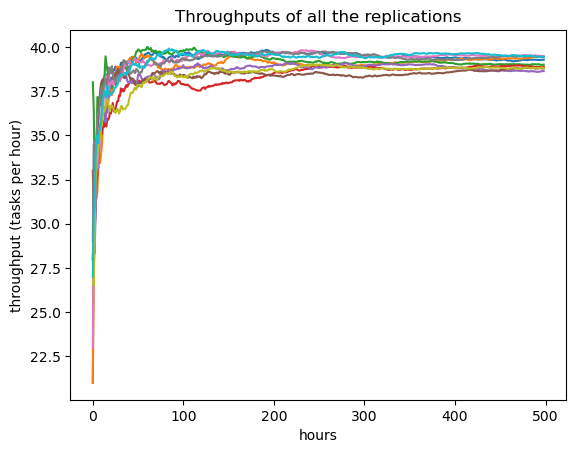

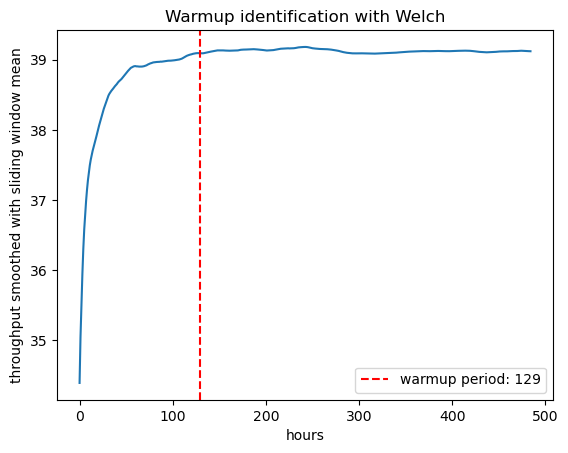

In [69]:
throughput_welch = MyWelch(replications_statistics["throughput"], 15, 0.02)
throughput_welch.plot_statistics()
throughput_welch.plot_weltch()

Evaluate throughput selecting only values registered after warmup period

In [100]:
def evaluate_steady_state_replications_mean(complete_statistics: List[List[int]], warmup_l: int):
    steady_state_replications_mean = []
    
    for replication in complete_statistics:
        steady_state_statistics = replication[warmup_l:]
        steady_state_replications_mean.append(np.array(steady_state_statistics).mean())
    
    return steady_state_replications_mean

In [102]:
def evaluate_confidence_interval(complete_statistics: List[List[int]], warmup_l: int, alpha):
    n = len(complete_statistics)
    
    steady_state_replications_means = evaluate_steady_state_replications_mean(replications_statistics["throughput"], throughput_welch.warmup_l)
    mean = np.array(steady_state_replications_means).sum() / len(steady_state_replications_means)
    
    variance = math.pow((np.array(steady_state_replications_means)-mean).sum(), 2) / (len(steady_state_replications_means)-1)
    
    t = scipy.stats.t.ppf(1-alpha, n-1)
    
    absolute_error = t * math.sqrt(math.pow(variance, 2)/ n)
    print(f"Confidence interval is {mean} +- {absolute_error}")

In [106]:
evaluate_confidence_interval(replications_statistics["throughput"], throughput_welch.warmup_l, 0.1)

Confidence interval is 39.125180092119486 +- 9.813616761202497e-30


## GOAL 2

Students must implement an alternative environment where, upon receiving a customer order, the order is placed into a “pre-shop pool” (PSP). At regular intervals, a reinforcement learning (RL) agent will decide whether to release the most urgent order from the PSP into the shopﬂoor.
The objective is to achieve:
- the same throughput as the PUSH system
- a comparable job tardiness 
- a comparable job earliness 
- lower WIP